In [1]:
import numpy as np
from qutip import basis
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
import matplotlib.pyplot as plt
from qutip.metrics import fidelity
from qutip import expect
from qutip import qeye, tensor
from quantum_logical.trotter import TrotterGroup
from tqdm import tqdm
from quantum_logical.operators import define_observables
from qutip import basis, tensor, Qobj
import numpy as np
from quantum_logical.interaction import ConversionGainInteraction

In [2]:
# Define the number of qubits
N = 3  # Number of qubits
delays = np.linspace(0, 25, 40)  # Sweeping delay from 0 to 10

# Assuming all qubits have the same T1 and T2
T1, T2 = 1, 1
trotter_step_size = 0.1

# hilbert space dim
d = 3
f_rho = basis(d, 2) * basis(d, 2).dag()  # |f><f|

# Define the N-qubit initial state |11...1> (N ones)
initial_state = tensor([f_rho] * N)
initial_state /= initial_state.norm()

observables, observable_labels = define_observables(N, d)

In [3]:
def multi_qudit_experiment(rho_initial, delay, trotter_step_size, unitary=None):
    amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=d)
    phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=d)

    trotter = TrotterGroup(
        continuous_operators=[amp_damp_channel, phase_damp_channel],
        trotter_dt=trotter_step_size,
    )

    rho_final = trotter.apply(rho_initial, delay, discrete_unitary=unitary)

    if unitary is None:
        rho_expected = rho_initial
    else:
        rho_expected = unitary * rho_initial * unitary.dag()

    # Calculate the fidelity
    fid = fidelity(rho_expected, rho_final)
    return rho_final, fid

In [4]:
def plot_observable_decay(
    state, observables, observable_labels, delays, trotter_step_size
):
    plt.figure(figsize=(4, 4))

    # Precompute the final states for each delay
    final_states = []
    for delay in tqdm(delays):
        rho_final, _ = multi_qudit_experiment(
            state, delay, trotter_step_size=trotter_step_size
        )
        final_states.append(rho_final)

    # Calculate and plot expectation values for each observable
    for label in observable_labels:
        obs = observables[label]
        exp_values = [expect(obs, rho_final) for rho_final in final_states]
        plt.plot(delays, exp_values, "-.", label=label)

    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title("Observable Expectation Values Over Time")
    plt.legend(ncols=N, loc="upper center", bbox_to_anchor=(0.5, -0.2))
    plt.show()

 12%|█▎        | 5/40 [00:00<00:00, 46.90it/s]

100%|██████████| 40/40 [00:03<00:00, 13.05it/s]


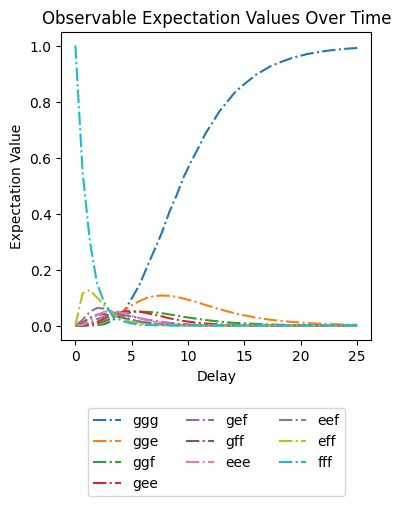

In [5]:
# Now call the updated function with labels
plot_observable_decay(
    initial_state,
    observables,
    observable_labels,
    delays,
    trotter_step_size,
)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:03<00:00, 12.68it/s]


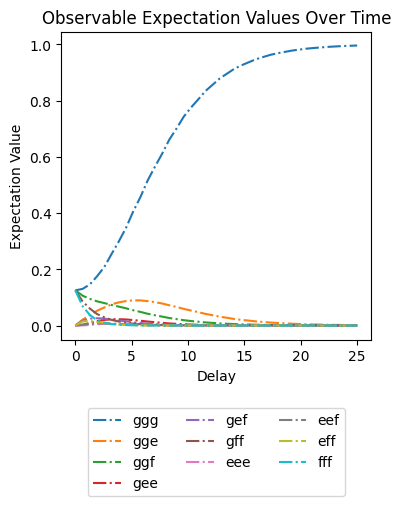

In [6]:
# Define encoded state to be [|g> + |f>]**N
encoded_state = basis(3, 0) + basis(3, 2)
encoded_state = encoded_state * encoded_state.dag()
encoded_state = tensor([encoded_state] * N)
encoded_state /= encoded_state.norm()

plot_observable_decay(
    encoded_state,
    observables,
    observable_labels,
    delays,
    trotter_step_size,
)